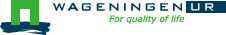

# A Jupyter notebook demonstrating how to run multiple simulations with PCSE/WOFOST

This Jupyter notebook will demonstrate how to implement a loop that can run multiple simulations using PCSE/WOFOST for water-limited conditions. Results are exported to an Excel file.

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;

Finally, you need a working internet connection.

## Importing the relevant modules

First the required modules need to be imported.

**Important:** For the example we will assume that data files are in the `data` directory within the directory where this notebook is located. This will be the case if you downloaded or cloned the repository from github.

In [1]:
import os, sys
data_dir = os.path.join(os.getcwd(), "data")
from itertools import product

import yaml
import pandas as pd

import pcse
from pcse.fileinput import CABOFileReader
from pcse.models import Wofost71_WLP_FD
from pcse.base import ParameterProvider
from pcse.exceptions import WeatherDataProviderError
from pcse.util import WOFOST71SiteDataProvider
from pcse.db import NASAPowerWeatherDataProvider
from progressbar import printProgressBar

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.4.2


## Setting up the parameters for crop, soil and site

Parameter files for crop and soil were taken from the [WOFOST Control Centre](http://www.wageningenur.nl/en/Expertise-Services/Research-Institutes/alterra/Facilities-Products/Software-and-models/WOFOST/Downloads.htm). These parameter file are in the `CABO` format which can be read the with `CABOFileReader` module.
### Crop parameter files

In [2]:
crop_dir = os.path.join(data_dir, 'crop')
crop_files = [CABOFileReader(os.path.join(crop_dir,f)) for f in os.listdir(crop_dir) if f.endswith("CAB")]

### Soil parameter files

In [3]:
soil_dir = os.path.join(data_dir, 'soil')
soil_files = [CABOFileReader(os.path.join(soil_dir,f)) for f in os.listdir(soil_dir) if f.startswith("ec")]


### Site parameters
Site parameters are an ancillary class of parameters that are related to a given site. For example, an important parameter is the initial amount of moisture in the soil profile (`WAV`) and the atmospheric CO2 concentration.

In [4]:
sited = WOFOST71SiteDataProvider(WAV=10, CO2=360., SMLIM=0.35)

## Agromanagement
Agromanagement can be defined in a file but often it is easier to define it directly as a string in the YAML format. Because the agromanagement needs to be updated for each year. It can thus be manipulated by string replacement and then parsed by the yaml parser. 

Here we define three agromanagement scenarios which define a crop calendar (no state or timed events) with suitable sowing dates for maize, potato and sugar beet in the Netherlands.

In [5]:
agro_maize = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'maize'
        crop_start_date: {year}-04-15
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""

agro_potato = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'potato'
        crop_start_date: {year}-05-01
        crop_start_type: sowing
        crop_end_date:
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""

agro_sugarbeet = """
- {year}-03-01:
    CropCalendar:
        crop_name: '{crop}'
        variety_name: 'sugar_beet'
        crop_start_date: {year}-05-01
        crop_start_type: sowing
        crop_end_date: {year}-10-15
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null
- {year}-12-01: null
"""
agro_templates = [agro_maize, agro_potato, agro_sugarbeet]

## Daily weather data

Weather data will be derived from the NASA POWER database which provides weather data at a resolution of 0.5x0.5 degree.

In [6]:
weatherdata = NASAPowerWeatherDataProvider(longitude=5, latitude=52)
print(weatherdata)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:    4.7
Latitude:  52.000
Longitude:  5.000
Data available for 1983-07-01 - 2021-01-25
Number of missing days: 6



### Exporting weather data
Weather data can also be easily exported to a dataframe for further analysis.

In [7]:
df = pd.DataFrame(weatherdata.export()).set_index("DAY")
df.head()

,LAT,LON,ELEV,IRRAD,TMIN,TMAX,VAP,RAIN,E0,ES0,ET0,WIND,TEMP
DAY,,,,,,,,,,,,,
1983-07-01,52.0,5.0,4.71,24880000.0,9.43,17.42,12.140438,0.041,0.454055,0.393142,0.355663,2.48,13.97
1983-07-02,52.0,5.0,4.71,10730000.0,10.67,19.69,14.118391,0.023,0.268569,0.241262,0.238727,3.27,15.47
1983-07-03,52.0,5.0,4.71,22930000.0,12.91,20.66,14.062675,0.004,0.461157,0.400849,0.386445,1.68,16.68
1983-07-04,52.0,5.0,4.71,25700000.0,12.07,23.48,15.882603,0.000,0.504024,0.435123,0.423567,1.17,18.28
1983-07-05,52.0,5.0,4.71,26030000.0,13.38,25.29,18.217738,0.001,0.557550,0.485744,0.450428,2.49,20.07


## Simulating with WOFOST

### Implementing the main loop
The following example implements a loop running over all years, crops and soil types. Daily output for each run is converted to a Pandas DataFrame and written as a separate excel file to an output folder. Summary results from all simulations is written to a separate excel file at the end of the simulation.

In [8]:
# Placeholder for storing summary results
summary_results = []

# Years to simulate
years = range(2004, 2008)

# Loop over crops, soils and years
crops_calendars = zip(crop_files, agro_templates)
all_runs = product(crops_calendars, soil_files, years)
nruns = len(years) * len(crop_files) * len(soil_files)

printProgressBar(0, nruns, prefix = 'Progress:', suffix = 'Complete', length = 50)
for i, inputs in enumerate(all_runs):
    (cropd, agro), soild, year = inputs
    crop_type = cropd['CRPNAM']
    soil_type = soild['SOLNAM']
    # String to identify this run
    run_id = "{crop}_{soil}_{year}".format(crop=crop_type, soil=soil_type, year=year)

    # Set the agromanagement with correct year and crop
    agromanagement = yaml.load(agro.format(year=year, crop=crop_type))

    # Encapsulate parameters
    parameters = ParameterProvider(sitedata=sited, soildata=soild, cropdata=cropd)

    # Start WOFOST, run the simulation 
    try:
        wofost = Wofost71_WLP_FD(parameters, weatherdata, agromanagement)
        wofost.run_till_terminate()
    except WeatherDataProviderError as e:
        msg = "Runid '%s' failed because of missing weather data." % run_id
        print(msg)
        continue
    printProgressBar(i+1, nruns, prefix = 'Progress:', suffix = 'Complete', length = 50)

    # convert daily output to Pandas DataFrame and store it
    df = pd.DataFrame(wofost.get_output()).set_index("day")
    fname = os.path.join(data_dir, "output", run_id + ".xls")
    df.to_excel(fname)

    # Collect summary results
    r = wofost.get_summary_output()[0]
    r['run_id'] = run_id
    summary_results.append(r)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


### Looking at the summary results
The summary results output provides a concise overview of the results of all simulations. If you are interested only in the final simulation results it is often more convenient to use the summary results. Moreover, some output (such as the date of anthesis - `DOA`) that is provided in the summary results cannot be easily gathered from the daily output.

In [9]:
# Write the summary results to an excel file
df_summary = pd.DataFrame(summary_results).set_index('run_id')
fname = os.path.join(data_dir, "output", "summary_results.xls")
df_summary.to_excel(fname)
df_summary.head()

,DVS,LAIMAX,TAGP,TWSO,TWLV,TWST,TWRT,CTRAT,RD,DOS,DOE,DOA,DOM,DOH,DOV,CEVST
run_id,,,,,,,,,,,,,,,,
"Grain maize 201, N-Germany, Luxembourg_EC1-coarse_2004",2.0,5.472462,23119.713188,10893.565464,3742.278665,8483.869059,2014.890189,28.662685,100.0,2004-04-15,2004-04-30,2004-07-23,2004-10-06,None,None,8.622791
"Grain maize 201, N-Germany, Luxembourg_EC1-coarse_2005",2.0,4.893520,23553.842350,12706.248769,3363.579026,7484.014555,1835.849464,27.747049,100.0,2005-04-15,2005-05-02,2005-07-21,2005-10-10,None,None,9.782565
"Grain maize 201, N-Germany, Luxembourg_EC1-coarse_2006",2.0,4.870825,16025.275975,7458.641857,3504.487833,5062.146285,2254.550830,20.141368,100.0,2006-04-15,2006-05-04,2006-07-14,2006-09-17,None,None,8.541137
"Grain maize 201, N-Germany, Luxembourg_EC1-coarse_2007",2.0,5.663595,26316.039415,13959.640487,3801.059840,8555.339087,2086.164839,30.026923,100.0,2007-04-15,2007-04-28,2007-07-12,2007-09-28,None,None,8.585140
"Grain maize 201, N-Germany, Luxembourg_EC2-medium_2004",2.0,5.472462,23442.151642,11216.003917,3742.278665,8483.869059,2014.890189,29.146427,100.0,2004-04-15,2004-04-30,2004-07-23,2004-10-06,None,None,8.595242


### Looking at the daily results
The excel files with the results from the batch simulation in the output folder should look like the figure below. Each excel file provides the results from a combination of crop, soil type and year.

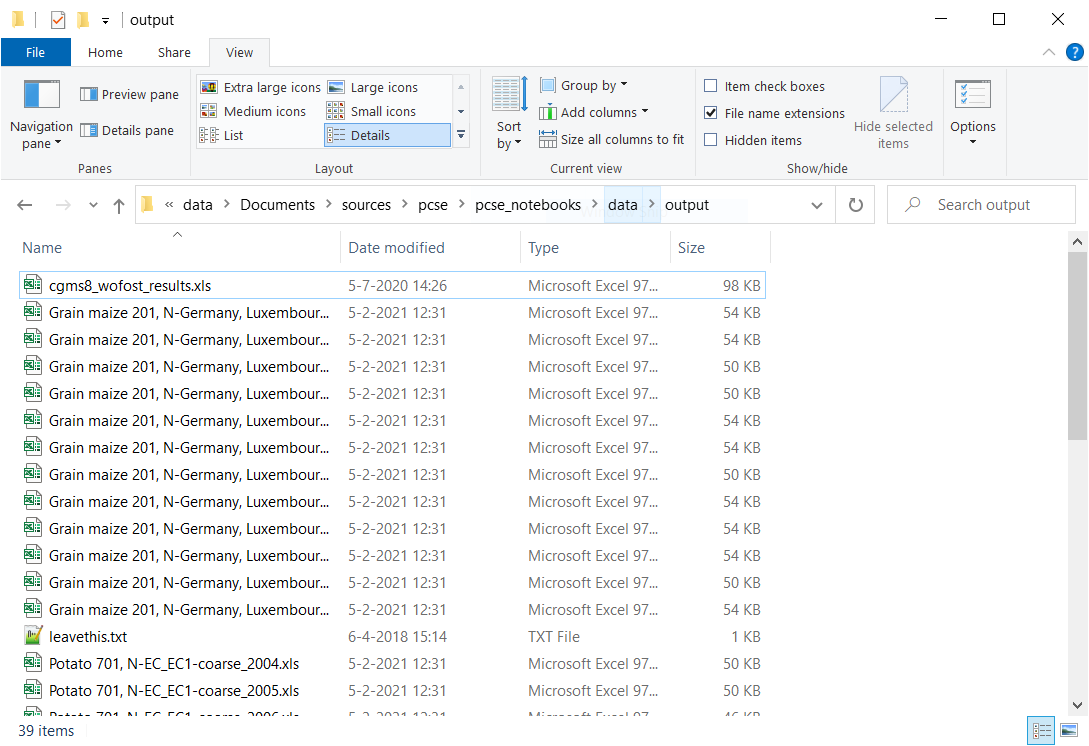